
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Jokin Cuesta Arrillaga</p>
</div>



#  MÉTODOS SUPERVISADOS

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican los puntos y con cuales obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. Exploración de algoritmos supervisados
    1. Naive-Bayes
    2. $k$ vecinos más próximos
    3. Support vector machines
    4. Árboles de decisión
    5. Random forest / Gradient boosting
2. Implementación del caso práctico
    1. Análisis descriptivo
    2. Preprocesamiento de los datos
    3. Entrenamiento del modelo
    4. Predicción de nuevos casos

In [1]:
# Librerías necesarias
import numpy as np 
import pandas as pd
import seaborn as sns

# Sklearn
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state


# Visualizar árboles
from IPython.display import Image
import pydotplus
from six import StringIO

# Visualización.
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!pip install pydotplus

## 1. Exploración de algoritmos supervisados

El conjunto de datos CIRCLES consiste en puntos en un plano que forman dos círculos, de aquí el nombre de "circles". Cada círculo corresponde a un grupo diferente [0, 1].

El siguiente código generará 1.000 puntos y hace un gràfico para visualizar los dos círculos (con colores diferentes para cada grupo). 

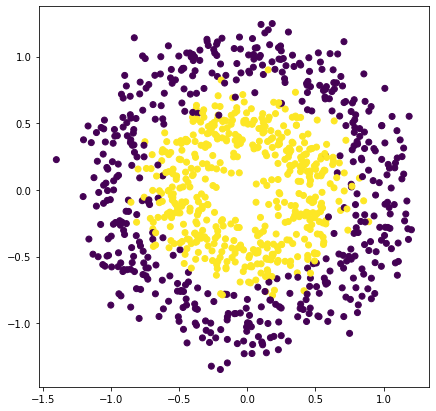

In [3]:
df = datasets.make_circles(n_samples=1000, factor=.5, noise=.15, random_state=42)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group)
plt.show()

Antes de aplicar ningún modelo, tenemos que separar los datos entre el conjunto de *train* y de *test*. Siempre trabajaremos sobre el conjunto de *train* y evaluaremos los resultados en *test*. Dividiremos el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombramos los conjuntos como: X_train, X_test, y_train, y_test. Utilizaremos la opción `random_state = 24`

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.2, random_state=24)

A lo largo de los ejercicios aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una _meshgrid_ con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde. También veremos las areas de indecisión, casos en los que el modelo no se inclina ni hacia una clase ni hacia otra (o si que se inclina pero no lo tiene 100% claro), estas seran blanquinosas.

In [5]:
# Vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = min(df_x)-0.1, max(df_x)+0.1
y_min, y_max = min(df_y)-0.1, max(df_y)+0.1 

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Hacemos reshape para tener el formato correcto.
    Z = Z.reshape(xx.shape)

    # Seleccionamos una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Dibujamos las fronteras de decisión.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Añadimos los puntos.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

### 1.1. Gaussian Naïve Bayes

El objetivo de este primer ejercicio es entender el funcionamiento del algoritmo Naïve-Bayes, un algoritmo peculiar ya que se basa completamente en teoría de probabilidades.

Con el dataset de _train_, entrenaremos un modelo Naïve-Bayes y representaremos gráficamente la frontera de decisión con el de _test_. Utilizaremos el clasificador **GaussianNB** de `sklearn`.
    
Calcularemos el _accuracy_ del modelo obtenido sobre _train_ y _test_ y la matriz de confusión sobre _test_. Utilizaremos `accuracy_score` y `confusion_matrix` del paquet `metrics` de `sklearn`.

El accuracy del modelo obtenido sobre train y test ha sido del 96.0 % 

El confusion matrix ha sido el siguiente:


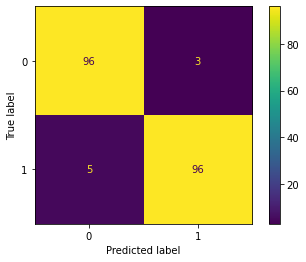

In [6]:
# Vamos a crear el modelo de GaussianNB
clf_gauss = GaussianNB()
model_gauss = clf_gauss.fit(X_train, y_train)

# Predecimos
y_pred = model_gauss.predict(X_test)

# Calculamos el accuracy del modelo
accu_model = accuracy_score(y_test, y_pred)
print(f'El accuracy del modelo obtenido sobre train y test ha sido del {accu_model*100} % \n')

# La matriz de confusión
print('El confusion matrix ha sido el siguiente:')
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_gauss.classes_)
disp.plot()
plt.show()

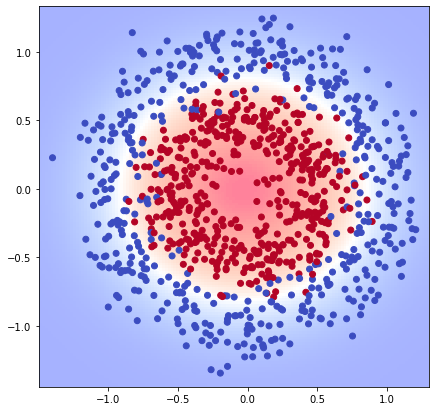

In [7]:
plot_decision_boundaries(df_x, df_y, df_group, model_gauss)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
Las fronteras de decisión son circulares, cuando se juntan puntos azules y rojos frontera de indecisión (más blanco). Tiene sentido con el modelo utilizado ya que sigue el teoría de probabilidades.
Las predicciones sobre el conjunto de test son muy buenas, 96% de accuracy, es decir 192 de 200.
</div>

### 1.2. KNN

El objetivo de este segundo ejercicio es entender el funcionamiento del KNN, intuir sus principales ventajas o desventajas y entender la influencia de los parámetros de los que está compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qué significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicción.

¿Cómo funciona KNN?

  - Calculamos la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos más cercanos, es decir, con menor distancia, según la distancia que utilizamos (euclídea, coseno, manhattan, etc).
  - Por último realizamos una "votación de mayoría" entre los k puntos: los de la clase que "dominan" decidirán su clasificación final.

<strong>Implementación:</strong>

Con el dataset de _train_, entrenamos un modelo KNN con `n_neighbors = 2` y representamos gráficamente la frontera de decisión con el de _test_.
    
Utilizaremos el clasificador **KNeighborsClassifier** de `sklearn`.

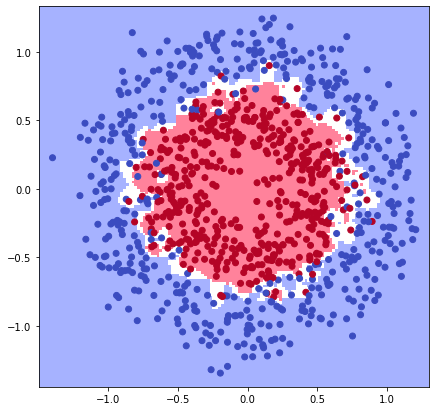

In [8]:
# Entrenamos el modelo de KNN y predecimos
clf_KN = KNeighborsClassifier(n_neighbors = 2)
model_KN = clf_KN.fit(X_train, y_train)
y_pred = model_KN.predict(X_test)

# Representamos la frontera de decisión
plot_decision_boundaries(df_x, df_y, df_group, model_KN)

En el modelo entrenado, hemos fijado el parámetro `n_neighbors` de forma arbitraria. Pero podría ser que con otro valor obtuviéramos una mejor predicción.

Para conocer el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_) se suele utilizar una búsqueda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinación de hiperparámetros posible y evaluarlo utilizando validación cruzada (_cross validation_) con 4 particiones estratificadas. Posteriormente, se elige la combinación de hiperparàmetres que mejores resultados haya obtenido.

En este caso sólo queremos optimizar un hiperparámetro:

   - 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.
   
Calcularemos del valor óptimo del hiperparámetro _k_ (`n_neighbors`) utilizando una búsqueda de rejilla con validación cruzada para encontrar el valor óptimo de _k_. Por cada valor, calcularemos su promedio y la desviación estándar. Implementaremos un _heatmap_ para visualizar la precisión según los diferentes valores del hiperparámetro.
    
Utilizaremos el módulo `GridSearchCV` de `sklearn` el cálculo del mejor hiperparámetro, y `heatmap` de `Seaborn`.

Este método presenta dos variables importantes que pueden determinar la bondad del método. Estas son, la métrica de similitud escogida y al valor de la propia k .Una de las distancias más utilizadas es la euclídea, especialmente en el caso de tratar con atributos numéricos. Pero hay más: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric

In [9]:
# Definimos los parámetros que probaremos
k_range = list(range(1, 11))
list_distance = ['euclidean','manhattan','chebyshev','minkowski']

# Creamos el modelo
model_KN = KNeighborsClassifier()
param_grid = dict(n_neighbors=k_range, metric = list_distance)

# Hacemos una búsqueda de rejilla para el cálculo del mejor hiperparámetro
grid = GridSearchCV(model_KN, param_grid, cv=4,scoring='precision')

# Fiteamos el modelo con los mejores hiperparámetros
grid_search = grid.fit(df[0], df[1])
print(f"El hiperparámetro con mayor precisión han sido los siguientes: {str(grid_search.best_params_)}")

El hiperparámetro con mayor precisión han sido los siguientes: {'metric': 'euclidean', 'n_neighbors': 6}


El heatmap con los valores medios de precision:


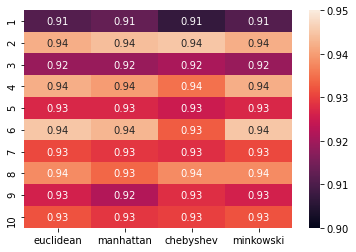

In [10]:
# Para realizar el promedio y la sd de la precisión de cada parámetro:
from sklearn.model_selection import cross_val_score

array_prom = np.eye(10,4)
array_sd = np.eye(10,4)
k = 0

# Probamos con todas las combinaciones
for j in list_distance:
    for i in k_range:
        clf_KN = KNeighborsClassifier(n_neighbors = i,metric = j).fit(X_train, y_train)
        #https://scikit-learn.org/stable/modules/cross_validation.html
        scores = cross_val_score(clf_KN, df[0], df[1],scoring = 'precision',cv=4)
        array_prom[i-1,k] = round(scores.mean(),3)
        array_sd[i-1,k] = round(scores.std(),3)
    k += 1
print('El heatmap con los valores medios de precision:')
ax = sns.heatmap(array_prom,vmin= 0.9, vmax=0.95,
            annot=True, xticklabels=['euclidean','manhattan','chebyshev','minkowski'],
            yticklabels = k_range)

El heatmap con las desviaciones estándares de precision:


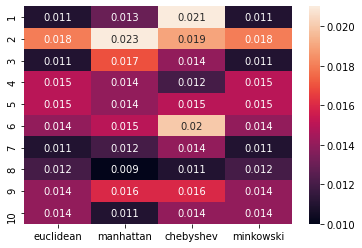

In [11]:
print('El heatmap con las desviaciones estándares de precision:')
ax = sns.heatmap(array_sd,vmin = 0.01, vmax = 0.021,
            annot=True, xticklabels=['euclidean','manhattan','chebyshev','minkowski'],
            yticklabels = k_range)

<strong>Implementación:</strong>


Con el mejor hiperparámetro encontrado, volveremos a entrenar un clasificador KNN (con _train_) y representaremos las fronteras de decisión con los puntos de _test_. Calcularemos el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión.

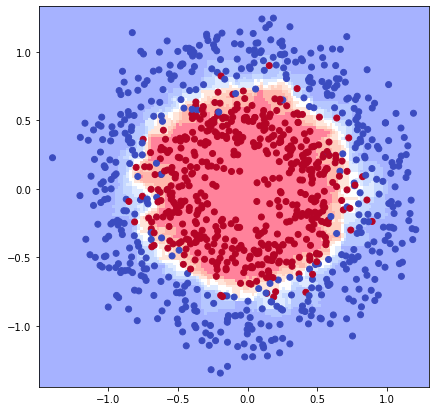

In [12]:
# Creamos el modelo con los mejores hiperparámetros
clf_KN = KNeighborsClassifier(n_neighbors = 8,metric = 'chebyshev')
model_KN = clf_KN.fit(X_train, y_train)
y_pred_KN = model_KN.predict(X_test)

# Dibujamos las fronteras de decisión
plot_decision_boundaries(df_x, df_y, df_group, model_KN)

El accuracy del modelo obtenido sobre train y test ha sido del 95.5 % 

El confusion matrix ha sido el siguiente:


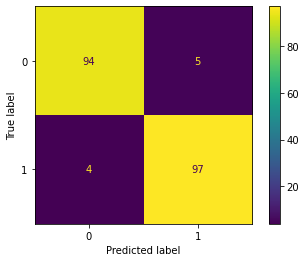

In [13]:
# Calculamos el accuracy
accu_model_KN = accuracy_score(y_test, y_pred_KN)
print(f'El accuracy del modelo obtenido sobre train y test ha sido del {accu_model_KN*100} % \n')
print('El confusion matrix ha sido el siguiente:')

# La matriz de confusión
cm_KN = confusion_matrix(y_test, y_pred_KN, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_KN, display_labels=clf_KN.classes_)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
Observando los mejores hiperparámetros se ha concluido que tanto n_neighbors = 8 y metric = chebyshev han sido los mejores. Los resultados obtenidos con GridSearchCV han coincidido con el heatmap realizado. El cambio de valor de n_neighbors se ve como las fronteras de decisión son más "suaves" mientras mayor sea este parámetro.Las fronteras de decisión ya no son circulares perfectas, sino que se ven como tiene salidas en la circunferencia. Las predicciones de test han sido buenas, el 95.5% ha sido acertado.
</div>

### 1.3. SVM

Las Support Vector Machine se fundamentan en el _Máximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones p-1. El término afín significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como _maximal margin hyperplane_ o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cómo de lejos está el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización.

El proceso de optimización tiene la peculiaridad de que sólo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del núcleo .

El truco del núcleo (_kernel trick_) consiste en utilizar una dimensión nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM también dependen de varios hiperparámetros. 

En este caso intentaremos optimizar dos hiperparámetros:

  - C: es la regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - gama: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto más pequeño es gama, más influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (_cross-validation_) con 4 particiones estratificadas.

<strong>Implementación:</strong> 

Calcularemos el valor óptimo de los hiperparámetros _C_ y _gama_. Utilizaremos una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcularemos su promedio y la desviación estándar. Haremos un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

In [14]:
# Volvemos a entrenar el modelo SVM
model_SVM = SVC()

# Definimos los parámetros a probar
C_list = [0.01, 0.1, 1, 10, 50, 100, 200]
gamma_list = [0.001, 0.01, 0.1, 1, 10]
param_grid_SVM = dict(C = C_list, gamma = gamma_list)

# Hacemos una búsqueda de rejilla para el cálculo del mejor hiperparámetro
grid = GridSearchCV(model_SVM, param_grid_SVM, cv=4,scoring='precision')

# Fiteamos el modelo con los mejores hiperparámetros
grid_search = grid.fit(df[0], df[1])
print(f"El hiperparámetro con mayor precisión han sido los siguientes: {str(grid_search.best_params_)}")

El hiperparámetro con mayor precisión han sido los siguientes: {'C': 0.01, 'gamma': 10}


El heatmap con los valores medios de precision:


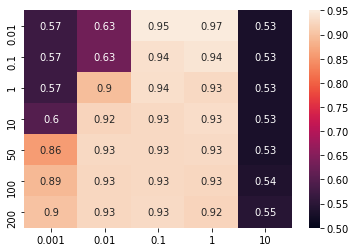

In [15]:
# Para realizar el promedio y la sd de la precisión de cada parámetro:
array_prom_SVM = np.eye(7,5)
array_sd_SVM = np.eye(7,5)
k = 0

# Probamos con todas las combinaciones
for j in gamma_list:
    l = 0
    for i in C_list:
        clf_SVM = SVC(C = i, gamma = j).fit(df[0],df[1])
        #https://scikit-learn.org/stable/modules/cross_validation.html
        scores_SVM = cross_val_score(clf_SVM, df[0], df[1],scoring = 'precision',cv=4)
        array_prom_SVM[l,k-1] = round(scores_SVM.mean(),3)
        array_sd_SVM[l,k-1] = round(scores_SVM.std(),3)
        l += 1
    k += 1

print('El heatmap con los valores medios de precision:')
ax = sns.heatmap(array_prom_SVM,vmin= 0.5, vmax=0.95,
            annot=True, xticklabels=gamma_list,
            yticklabels = C_list)

El heatmap con las desviaciones estándares de precision:


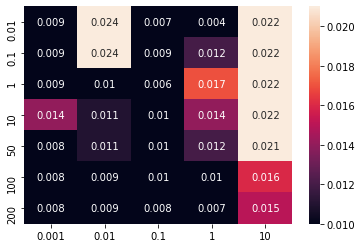

In [16]:
print('El heatmap con las desviaciones estándares de precision:')
ax = sns.heatmap(array_sd_SVM, vmin = 0.01, vmax = 0.021,
            annot=True, xticklabels=gamma_list,
            yticklabels = C_list)

<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encuentrada, entrenaremos un clasificador `SVM` (con _train_) y representaremos las fronteras de decisión con los puntos de _test_. Calcularemos el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión.

In [17]:
# Entrenamos el modelo con la mejor combinación
clf_SVM = SVC(C = 0.1, gamma = 10)
model_SVM = clf_SVM.fit(X_train, y_train)
y_pred_SVM = model_SVM.predict(X_test)

#plot_decision_boundaries(df_x, df_y, df_group, model_SVM)

Se ha obtenido un error al dibujar las fronteras de decisión: predict_proba is not available when  probability=False. El cual no se ha conseguido solucionar.

El accuracy del modelo obtenido sobre train y test ha sido del 96.5 % 

El confusion matrix ha sido el siguiente:


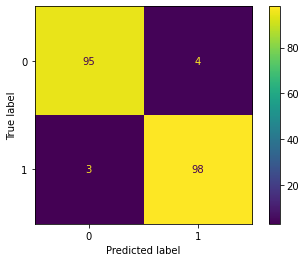

In [18]:
# Accuracy
accu_model_SVM = accuracy_score(y_test, y_pred_SVM)
print(f'El accuracy del modelo obtenido sobre train y test ha sido del {accu_model_SVM*100} % \n')

# Matriz de confusión
print('El confusion matrix ha sido el siguiente:')
cm_SVM = confusion_matrix(y_test, y_pred_SVM, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_SVM, display_labels=clf_SVM.classes_)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
Los resultados concluyen que los mejores hiperparámetros son C = 0.1 y gamma = 10. No he podido dibujar las fronteras de decisión por el error obtenido, por lo que no puedo concluir su forma. Los resultados han sido de 96.5%, muy buenas.
</div>

### 1.4. Árboles de decisión

Los árboles de decisión son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Los árboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcción de un árbol

La creación de las ramificaciones de los árboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del árbol, donde todas las observaciones pertenecen a la misma región.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se evalúan las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entropía, chi-square.

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperparámetros:

   - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el número mínimo de observaciones que debe tener una hoja del árbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

<strong>Implementación:</strong>

Calcularemos el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split`. Utilizaremos una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcularemos su promedio y la desviación estándar. Haremos un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
</div>

In [19]:
# Definimos todos los hiperparámetros
max_depth = range(4,11)
min_samples_split = [2,10,20,50,100]
parameters = {
    "max_depth": max_depth,
    "min_samples_split": min_samples_split
}

# Buscamos los mejores hiperparámetros
model_tree = DecisionTreeClassifier()
clf_tree = GridSearchCV(model_tree, parameters, scoring = 'precision', cv = 4)
grid_search = clf_tree.fit(df[0],df[1])

print(f"El hiperparámetro con mayor precisión han sido los siguientes: {str(grid_search.best_params_)}")

El hiperparámetro con mayor precisión han sido los siguientes: {'max_depth': 4, 'min_samples_split': 100}


El heatmap con los valores medios de precision:


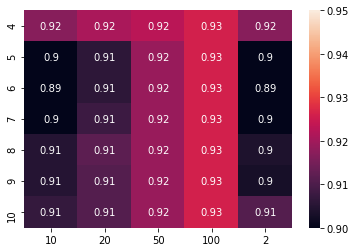

In [20]:
# Para el heatmap:
array_prom_tree = np.eye(7,5)
array_sd_tree = np.eye(7,5)

# Probamos todas las combinaciones
k = 0
for j in min_samples_split:
    l = 0
    for i in max_depth:
        clf_tree = DecisionTreeClassifier(max_depth = i, min_samples_split = j).fit(df[0],df[1])
        #https://scikit-learn.org/stable/modules/cross_validation.html
        scores_tree = cross_val_score(clf_tree, df[0], df[1],scoring = 'precision',cv=4)
        array_prom_tree[l,k-1] = round(scores_tree.mean(),3)
        array_sd_tree[l,k-1] = round(scores_tree.std(),3)
        l += 1
    k += 1

print('El heatmap con los valores medios de precision:')
ax = sns.heatmap(array_prom_tree,vmin= 0.9, vmax=0.95,
            annot=True, xticklabels=[10,20,50,100,2],
            yticklabels = max_depth)

El heatmap con las desviaciones estándares de precision:


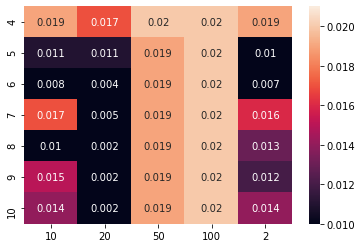

In [21]:
print('El heatmap con las desviaciones estándares de precision:')
ax = sns.heatmap(array_sd_tree, vmin = 0.01, vmax = 0.021,
            annot=True, xticklabels=[10,20,50,100,2],
            yticklabels = max_depth)

<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrados, entrenaremos un clasificador `DecisionTreeClassifier` (con `train`) y representar las fronteras de decisión con los puntos de `test`. Calcularemos el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión.
</div>

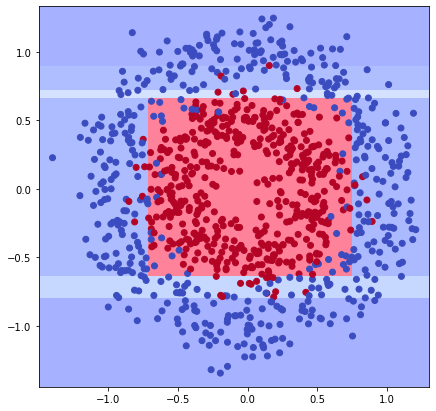

In [22]:
# Entrenamos el modelo
clf_tree = DecisionTreeClassifier(max_depth = 4, min_samples_split = 100)
model_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

# Dibujamos las fronteras de decisión
plot_decision_boundaries(df_x, df_y, df_group, model_tree)

El accuracy del modelo obtenido sobre train y test ha sido del 92.0 % 

El confusion matrix ha sido el siguiente:


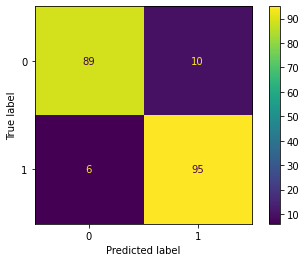

In [23]:
# Calculamos el accuracy
accu_model_tree = accuracy_score(y_test, y_pred_tree)
print(f'El accuracy del modelo obtenido sobre train y test ha sido del {accu_model_tree*100} % \n')
print('El confusion matrix ha sido el siguiente:')

# Obtenemos la matriz de confusión:
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=clf_tree.classes_)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
Los mejores hiperparámetros han sido max_depth = 4 y min_samples_split = 100. Las fronteras de decisión son cuadradas, algo que tiene sentido con el algoritmo utilizado. Las predicciones han sido buenas (92%), pero ligeramente peores que con los otros modelos.
</div>

### 1.5. Mejorando los árboles de decisión

En la práctica, casi nunca se utiliza un solo árbol de decisión, sino que se combinan muchos árboles para obtener mejores resultados. Hay dos maneras de combinar árboles:

  - *__Bagging__*: utilizar el conjunto de entrenamiento original para generar centenar o miles de conjuntos similares utilizando muestreo con reemplazo. El algoritmo _random forest_ está basado en este concepto, la combinación de varios árboles de decisión, cada uno entrenado con una muestra diferente de los datos. La decisión final del clasificador combinado (la _random forest_) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).
  
  - *__Boosting__*: se combinan varios clasificadores débiles secuencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificadas en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.
  
Ambos métodos los estudiaremos más en detalle en la próxima PEC, pero en esta haremos un vistazo a los beneficios que nos aporta utilizar combinaciones de árboles respecto un solo árbol.

Al tratarse de árboles, sigue siendo importante optimizar `max_depth` y `min_samples_split`, pero en este caso añadiremos un hiperparámetro más. Para simplificar, de los dos parámetros anteriores optimizaremos sólo `max_depth`:

  - `n_estimators`: número de árboles. Exploraremos los valores: 50, 100 y 200.
  - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 8 y 12.

<strong>Implementación:</strong>

Escogeremos uno de los dos algoritmos mencionados: RandomForestClassifier o GradientBoostingClassifier. Calcularemos el valor óptimo de los hiperparámetros `n_estimators` y `max_depth`. Utilizaremos una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcularemos su promedio y la desviación estándar. Haremos un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
<u>Nota</u>: al utilizar tantos árboles, el _cross validation_ con todas las combinaciones de parámetros es más costosa que en los ejemplos anteriores, y por lo tanto tardará más en ejecutarse.
</div>

In [24]:
# Definimos todos los hiperparámetros
n_estimators = [50,100,200]
max_depth = range(8,13)
parameters = {
    "n_estimators" : n_estimators,
    "max_depth": max_depth
}
# Buscamos la mejor combinación
model_rforest = RandomForestClassifier()
clf_rforest = GridSearchCV(model_rforest, parameters, scoring = 'precision', cv = 4)
# Probamos con la mejor combinación 
grid_search = clf_rforest.fit(df[0],df[1])

print(f"El hiperparámetro con mayor precisión han sido los siguientes: {str(grid_search.best_params_)}")

El hiperparámetro con mayor precisión han sido los siguientes: {'max_depth': 11, 'n_estimators': 100}


El heatmap con los valores medios de precision:


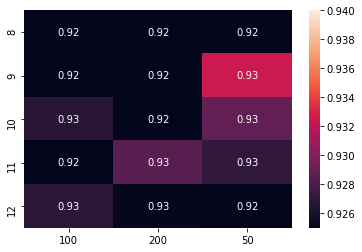

In [25]:
# Probamos con todas las combinaciones para obtener el heatmap
array_prom_rforest = np.eye(5,3)
array_sd_rforest = np.eye(5,3)
k = 0
for j in n_estimators:
    l = 0
    for i in max_depth:
        clf_rforest = RandomForestClassifier(n_estimators = j, max_depth = i).fit(df[0],df[1])
        #https://scikit-learn.org/stable/modules/cross_validation.html
        scores_rforest = cross_val_score(clf_rforest, df[0], df[1],scoring = 'precision',cv=4)
        array_prom_rforest[l,k-1] = round(scores_rforest.mean(),5)
        array_sd_rforest[l,k-1] = round(scores_rforest.std(),5)
        l += 1
    k += 1

print('El heatmap con los valores medios de precision:')
ax = sns.heatmap(array_prom_rforest,vmin= 0.925, vmax=0.940,
            annot=True, xticklabels = [100,200,50],
            yticklabels =max_depth)

El heatmap con las desviaciones estándares de precision:


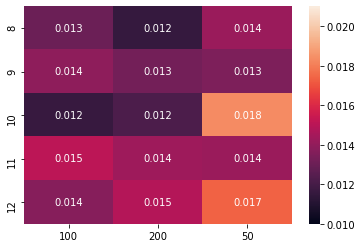

In [26]:
print('El heatmap con las desviaciones estándares de precision:')
ax = sns.heatmap(array_sd_rforest, vmin = 0.01, vmax = 0.021,
            annot=True, xticklabels=[100,200,50],
            yticklabels = max_depth)

<strong>Implementación:</strong>

Con la mejor combinación de hiperparámetros encontrada, entrenaremos un clasificador `DecisionTreeClassifier` (con _train_) y representar las fronteras de decisión con los puntos de test. Calcularemos el _accuracy_ del modelo obtenido sobre test y la matriz de confusión.
</div>

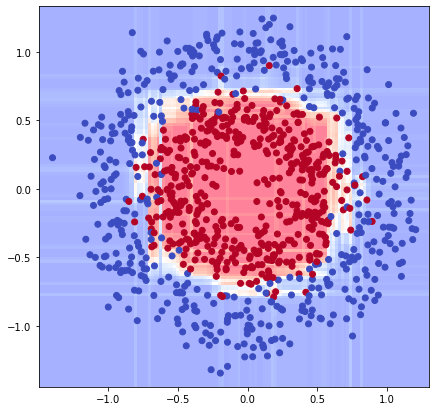

In [27]:
# Entrenamos el modelo y predecimos
clf_tree = RandomForestClassifier(max_depth = 12, n_estimators = 50)
model_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

# Dibujamos las fronteras de decisión
plot_decision_boundaries(df_x, df_y, df_group, model_tree)

El accuracy del modelo obtenido sobre train y test ha sido del 93.5 % 

El confusion matrix ha sido el siguiente:


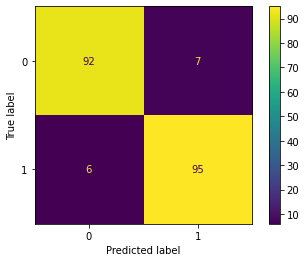

In [28]:
# Calculamos el accuracy
accu_model_tree = accuracy_score(y_test, y_pred_tree)
print(f'El accuracy del modelo obtenido sobre train y test ha sido del {accu_model_tree*100} % \n')
print('El confusion matrix ha sido el siguiente:')

# Matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=clf_tree.classes_)
disp.plot()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

Los mejores hiperparámetros han sido max_depth =  12 y n_estimators = 50. Las fronteras de decisión son menos cuadradas. Las predicciones obtenidas han tenido un accuracy de 95%, por lo que ha habido mejora respecto a utilizar un simple árbol de decisión.
</div>

# 2. Implementación del caso práctico

Para este ejercicio se proporciona un _dataset_ con datos sobre diferentes clientes de un banco que quieren comprar un piso, y si el banco les ha concedido la hipoteca o no. 

La información es la siguiente:

  - `ingresos`: los ingresos mensuales de la familia.
  - `gastos_comunes`: pagos mensuales de luz, agua, gas, etc.
  - `pago_coche`: si se está pagando cuota por uno o más coches, y los gastos mensuales en combustible, etc.
  - `gastos_otros`: compra mensual en supermercado y lo necesario para vivir.
  - `ahorros`: suma de ahorros dispuestos a utilizar para la compra de la casa.
  - `vivienda`: precio de la vivienda que quiere comprar esta familia.
  - `estado_civil`: 0-soltero, 1-casados, 2-divorciados
  - `hijos`: cantidad de hijos menores y que no trabajan.
  - `trabajo`: 0-sin empleo, 1-autónomo (freelance), 2-empleado, 3-empresario, 4-pareja: autónomos, 5-pareja: empleados, 6-pareja: autónomo y asalariado, 7-pareja: empresario y autónomo , 8-pareja: empresarios los dos o empresario y empleado
  - `hipoteca`: 0-No ha sido concedida, 1-Si que ha sido concedida (esta será nuestra columna de salida, para aprender)
  
Empezamos leyendo el _dataset_ y viendo una muestra de las primeras filas.

In [29]:
hipotecas = pd.read_csv("hipotecas.csv")
hipotecas.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,hipoteca
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


### 2.1. Análisis descriptivo

Cuando se nos proporciona un _dataset_, antes de empezar a hacer nada, es muy importante hacer un análisis exploratorio para conocer los datos con los que trabajaremos. Calcularemos las frecuencias de la variable _target_ (`hipoteca`). Analizar la distribución de las otras variables con gráficos de barras las variables categóricas y con histogramas las variables numéricas.

0    135
1     67
Name: hipoteca, dtype: int64


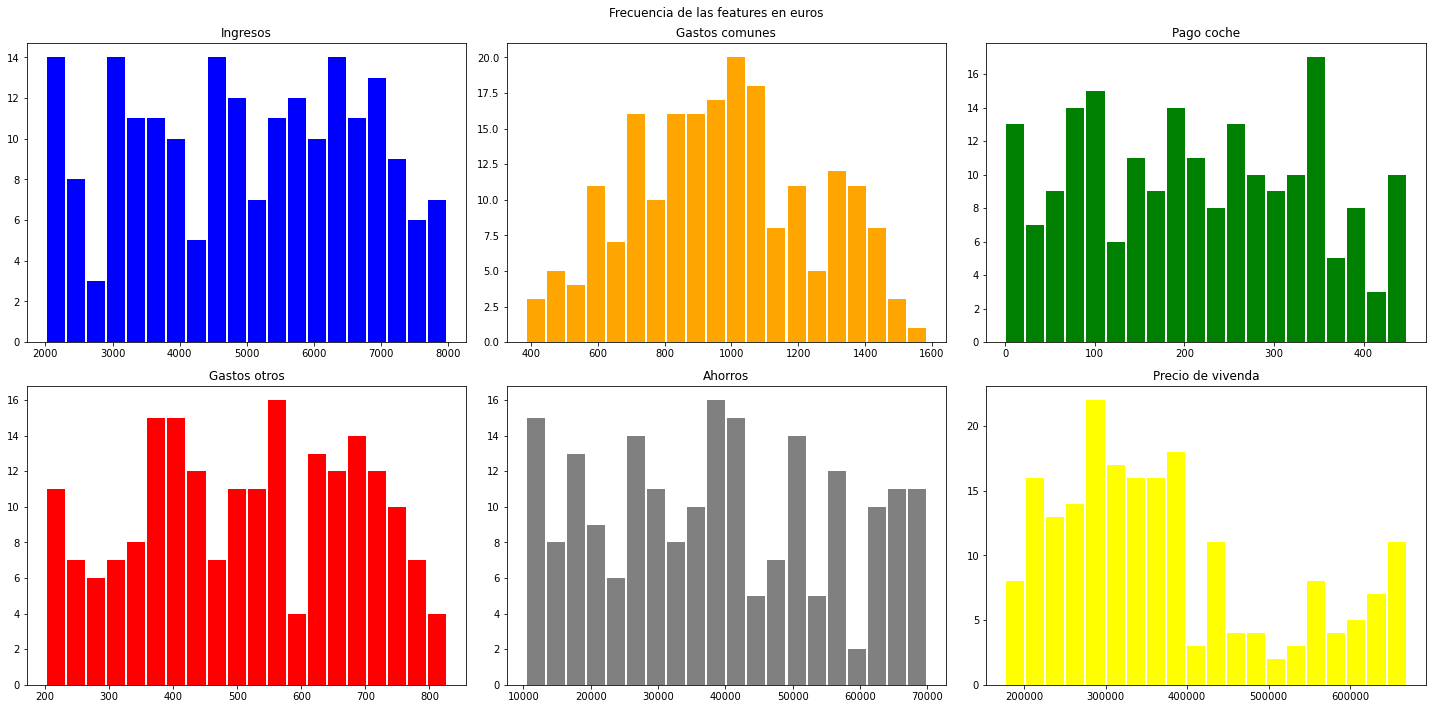

In [30]:
# Cálculo frecuencia hipoteca:
freq = hipotecas['hipoteca'].value_counts()
print(freq)

# Distribución de otras variables númericas:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
axs[0, 0].hist(hipotecas['ingresos'], align = 'mid', rwidth = 0.9, bins = 20, color = 'blue')
axs[0, 0].set_title('Ingresos')

axs[0, 1].hist(hipotecas['gastos_comunes'], align = 'mid', rwidth = 0.9, bins = 20, color = 'orange')
axs[0, 1].set_title('Gastos comunes')

axs[0, 2].hist(hipotecas['pago_coche'], align = 'mid', rwidth = 0.9, bins = 20, color = 'green')
axs[0, 2].set_title('Pago coche')

axs[1, 0].hist(hipotecas['gastos_otros'], align = 'mid', rwidth = 0.9, bins = 20, color = 'red')
axs[1, 0].set_title('Gastos otros')

axs[1, 1].hist(hipotecas['ahorros'], align = 'mid', rwidth = 0.9, bins = 20, color = 'gray')
axs[1, 1].set_title('Ahorros')

axs[1, 2].hist(hipotecas['vivienda'], align = 'mid', rwidth = 0.9, bins = 20, color = 'yellow')
axs[1, 2].set_title('Precio de vivenda')

plt.suptitle('Frecuencia de las features en euros')
fig.tight_layout()

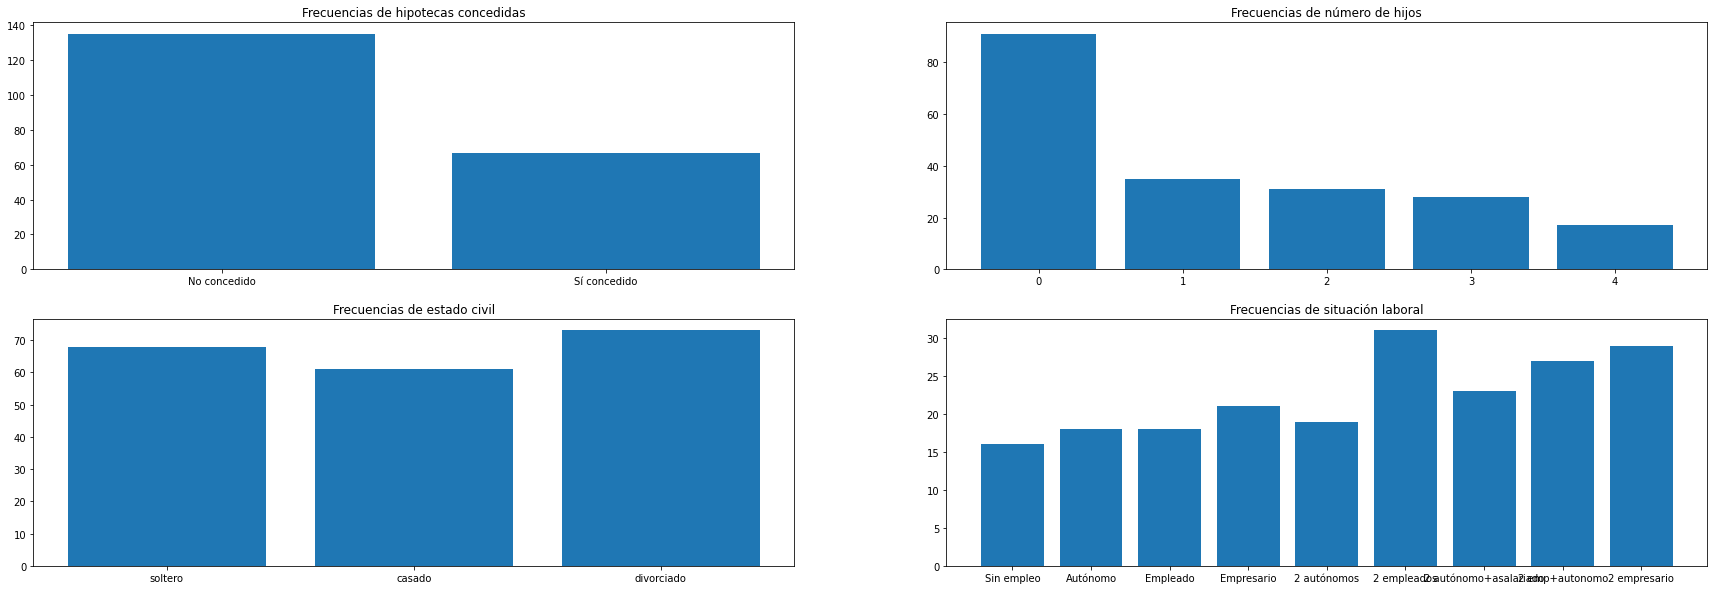

<Figure size 1440x432 with 0 Axes>

In [31]:
# Dibujamos
fig, axs = plt.subplots(2, 2, figsize=(30,10))

# Gráficos de barras de variables categóricas
freq0 = hipotecas['hipoteca'].value_counts()
axs[0,0].bar(['No concedido','Sí concedido'], height = [freq0[0],freq0[1]])
axs[0,0].set_title('Frecuencias de hipotecas concedidas')

# ESTADO CIVIL
freq1 = hipotecas['estado_civil'].value_counts()
axs[1,0].bar(['soltero','casado','divorciado'], height = [freq1[0],freq1[1],freq1[2]])
axs[1,0].set_title('Frecuencias de estado civil')

# HIJOS
freq2 = hipotecas['hijos'].value_counts()
axs[0,1].bar(['0','1','2','3','4'], height = [freq2[0],freq2[1],freq2[2],freq2[3],freq2[4]])
axs[0,1].set_title('Frecuencias de número de hijos')

# TRABAJO
plt.figure(figsize=(20, 6))
freq3 = hipotecas['trabajo'].value_counts()
axs[1,1].bar(['Sin empleo','Autónomo','Empleado','Empresario','2 autónomos','2 empleados', '2 autónomo+asalariado','2 emp+autonomo','2 empresario'], height = [freq3[0],freq3[1],freq3[2],freq3[3],freq3[4],freq3[5],freq3[6],freq3[7],freq3[8]])
axs[1,1].set_title('Frecuencias de situación laboral')
plt.show()

### 2.2. Preprocesamiento de los datos

Una vez hecho un primer análisis, se trata de "limpiar" el dataset y adaptarlo a nuestras necesidades (en este caso, predecir si se concederá la hipoteca o no). Comprobamos si hay valores `null`.

In [32]:
hipotecas.isnull().values.any()

False

No hay ningún valor null.

<strong>Implementación:</strong> 

- Agruparemos los diversos gastos mensuales (`pago_coche` + `gastos_comunes` + `gastos_otros`) en una variable llamada `gastos`.
- Calcularemos el montante a financiar en una variable llamada `financiar`. Para ello creamos una columna llamada `financiar` que será el resto del precio de la vivienda con los ahorros de la familia.
- Eliminamos las variables utilizadas para crear estas nuevas columnas.
</div>

In [33]:
# Creamos la variable gastos y eliminamos las necesarias
hipotecas['gastos'] = hipotecas['pago_coche'] + hipotecas['gastos_comunes'] + hipotecas['gastos_otros']
hipotecas = hipotecas.drop(columns=['pago_coche','gastos_comunes','gastos_otros'])

In [34]:
# Creamos la variable financiar y eliminamos las necesarias
hipotecas['financiar'] = hipotecas['vivienda'] - hipotecas['ahorros']
hipotecas = hipotecas.drop(columns= ['ahorros','vivienda'])
hipotecas.head()

,ingresos,estado_civil,hijos,trabajo,hipoteca,gastos,financiar
0,6000,0,2,2,1,1600,350000
1,6745,1,3,6,0,1496,593657
2,6455,2,1,8,1,1926,264316
3,7098,0,0,3,0,1547,606427
4,6167,0,0,3,1,1606,307420


El siguiente paso sería ver la correlación entre todas las _features_ numéricas. Esto se hace para asegurar que no hay dos variables muy relacionadas entre sí, ya que en tal caso se debería seleccionar una de las dos o combinarlas en una nueva. Mostraremos la correlación entre todas las _features_ numéricas. Si hay dos con una correlación superior al 80%, eliminaremos una de las dos. Utilizaremos `heatmap` de `Seaborn`, para verlas en un mapa de colores.

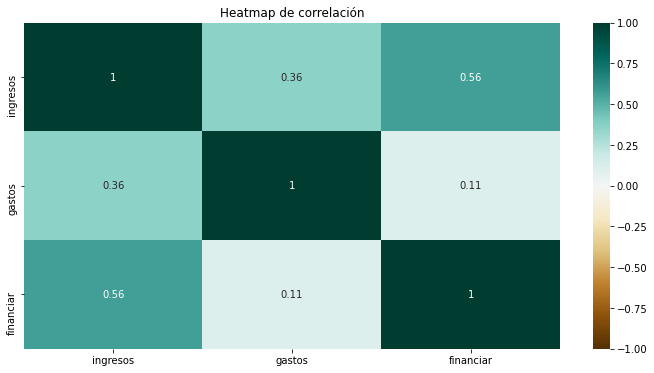

In [35]:
# Creamos un dataframe con las features numéricas
numericos = hipotecas.drop(['estado_civil','hijos','trabajo','hipoteca'],axis=1)
plt.figure(figsize=(12, 6))

# Definimos el heatmap con las correlaciones
heatmap = sns.heatmap(numericos.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Heatmap de correlación')
plt.show()

Ninguna de las features tiene un grado de correlación superior al 80%, por lo que conservaremos todas ellas. Las features con mayor correlación son ingresos-financiar (corr = 0.56) y gastos-ingresos (0.36).

Ya tenemos las variables finales con las que trabajaremos. Vamos a observar ahora cuál es la relación de cada una de ellas con el `target`. Repetiremos los diagramas de barras y los histogramas, separando por colores la variable _target_ (dentro del mismo gráfico, diferenciando entre hipoteca-sí y hipoteca-no).

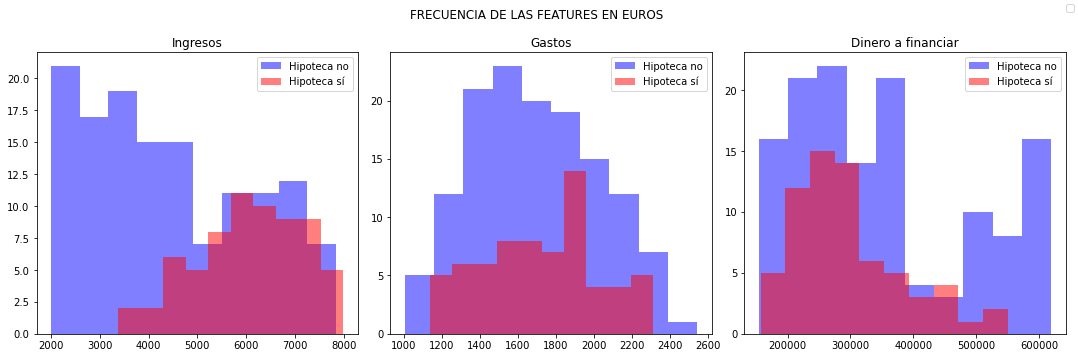

In [36]:
# Barras e histogramas separados por colores la variable target.

# Distribución de otras variables númericas:
fig, axs = plt.subplots(1,3,figsize=(15,5))
labels = ["Hipoteca no","Hipoteca sí"]
fig.legend(labels)

# INGRESOS
ingreso_zero = hipotecas[hipotecas["hipoteca"] == 0]["ingresos"]
ingreso_one = hipotecas[hipotecas["hipoteca"] == 1]["ingresos"]

axs[0].hist(ingreso_zero, alpha=0.5, label = "No",color='blue')
axs[0].hist(ingreso_one, alpha=0.5, label = "Sí",color='red')
axs[0].labels = ["Hipoteca no","Hipoteca sí"]
axs[0].legend(labels)
axs[0].set_title('Ingresos')

# GASTOS
gascom_zero = hipotecas[hipotecas["hipoteca"] == 0]["gastos"]
gascom_one = hipotecas[hipotecas["hipoteca"] == 1]["gastos"]
axs[1].hist(gascom_zero, alpha=0.5, label = "No",color='blue')
axs[1].hist(gascom_one, alpha=0.5, label = "Sí",color='red')
axs[1].legend(labels)
axs[1].set_title('Gastos')

# FINANCIAR
vivienda_zero = hipotecas[hipotecas["hipoteca"] == 0]["financiar"]
vivienda_one = hipotecas[hipotecas["hipoteca"] == 1]["financiar"]

axs[2].hist(vivienda_zero, alpha=0.5, label = "No",color='blue')
axs[2].hist(vivienda_one, alpha=0.5, label = "Sí",color='red')
axs[2].legend(labels)
axs[2].set_title('Dinero a financiar')

plt.suptitle('FRECUENCIA DE LAS FEATURES EN EUROS')
fig.tight_layout()

Finalmente, sólo nos queda pasar las variables categóricas a numéricas. Observamos que a pesar de que todas las variables tengan números, esto no quiere decir que sean numéricas. Por ejemplo, la variable `estado_civil` tiene los valores 0-1-2, que sería lo mismo que si tuviera los valores soltero-casado-divorciado. Hay otras variables donde esto no ocurre, por ejemplo el número de hijos, que a pesar de ser categórica sí que son números, ya que es ordinal. La manera de diferenciarlo es, en el caso del número de hijos, 1 hijo es menos que 2 hijos, mientras que con el estado civil no hay un orden.

Una manera de pasar las variables categóricas en numéricas es aplicando _one-hot encoding_. Por ejemplo, en el caso de la variable `estado_civil`, lo que se haría sería crear tres columnas nuevas: `soltero`, `casado` y `divorciado`. Estas columnas tendrían los valores 0-1, por ejemplo, en el caso de la columna `soltero` tendría el valor 1 cuando `estado_civil = soltero`, y cero en otro caso.

<strong>Implementación:</strong>

Aplicaremos _one-hot-encoding_ a las variables categóricas que lo requieran. Eliminaremos las variables originales.
    
Utilizaremos `OneHotEncoder` de `sklearn.preprocessing`. https://xgdgsc.wordpress.com/2015/03/20/note-on-using-onehotencoder-in-scikit-learn-to-work-on-categorical-features/
</div>

In [37]:
# One hot Encoder
encoder = OneHotEncoder(sparse = False)

# Estado civil
onehot_estado = encoder.fit_transform(hipotecas[['estado_civil']])
estado = pd.DataFrame(onehot_estado, columns = encoder.categories_)
estado = estado.rename(columns={0:"soltero",1:"casado",2:"divorciado"})
hipotecas = hipotecas.drop(["estado_civil"],axis=1)
hipotecas = hipotecas.join(estado)

# Trabajo
onehot_trabajo = encoder.fit_transform(hipotecas[['trabajo']])
trabajo = pd.DataFrame(onehot_trabajo, columns=encoder.categories_)
trabajo = trabajo.rename(columns={0:'sin empleo',1:"freelance",2:"empleado",3:"empresario",4:"par_freelance",5:"par_empleados",6:"par_autonomo_asalariado",7:"par_empresario_freelance",8:"par_empresario2"})
hipotecas = hipotecas.drop(["trabajo"],axis=1)
hipotecas = hipotecas.join(trabajo)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
Es necesario hacer one-hot encoding para convertir las variables categóricas en numéricas. Si tenemos una columna estado_civil en vez de tres columnas soltero, casado y divorciado, la feature podría tener 3 opciones, por lo que es más costoso. El modelo hubiera funcionado, pero a nivel conceptual las variables tienen que ser binarias.
</div>

### 2.3. Entrenamiento de un modelo

Ahora que ya tenemos el _dataset_ limpio y hemos hecho un análisis de las diferentes variables, podemos proceder a entrenar un modelo para predecir si se concede una hipoteca o no. 

Probaremos con 2 modelos diferentes e interpretaremos los resultados. 

Para empezar, separamos el dataset entre _train_ y _test_.

In [38]:
# Sacamos la variable target del dataframe
target = hipotecas['hipoteca']
hipotecas = hipotecas.drop(['hipoteca'],axis=1)

# Dividimos el dataset en train (80%) y test(%20%)
X_train, X_test, y_train, y_test = train_test_split(hipotecas, target, test_size=0.2, random_state=24)

<strong>Implementación:</strong>

Utilizaremos un árbol de decisión simple con `max_depth = 5` para acotar el dataset "hipotecas" sobre el conjunto de _train_. Dibujaremos el árbol de decisión. Calcularemos el _accuray_ y la matriz de confusión sobre _train_ y sobre _test_.
    
Para dibujar el árbol, podemos guiaros con este enlace: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

El accuracy del modelo obtenido sobre train y test ha sido del 80.488 % 

El confusion matrix ha sido el siguiente:


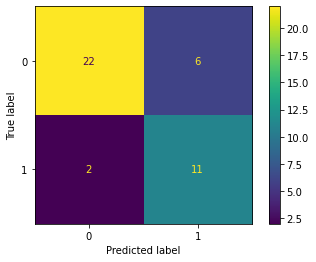

In [39]:
# Entrenamos el modelo
clf = DecisionTreeClassifier(max_depth = 5)
modelo = clf.fit(X_train, y_train)
y_pred= modelo.predict(X_test)

# Accuracy y matriz de confusión
accu = accuracy_score(y_test, y_pred)
print(f'El accuracy del modelo obtenido sobre train y test ha sido del {round(accu*100,3)} % \n')
print('El confusion matrix ha sido el siguiente:')
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

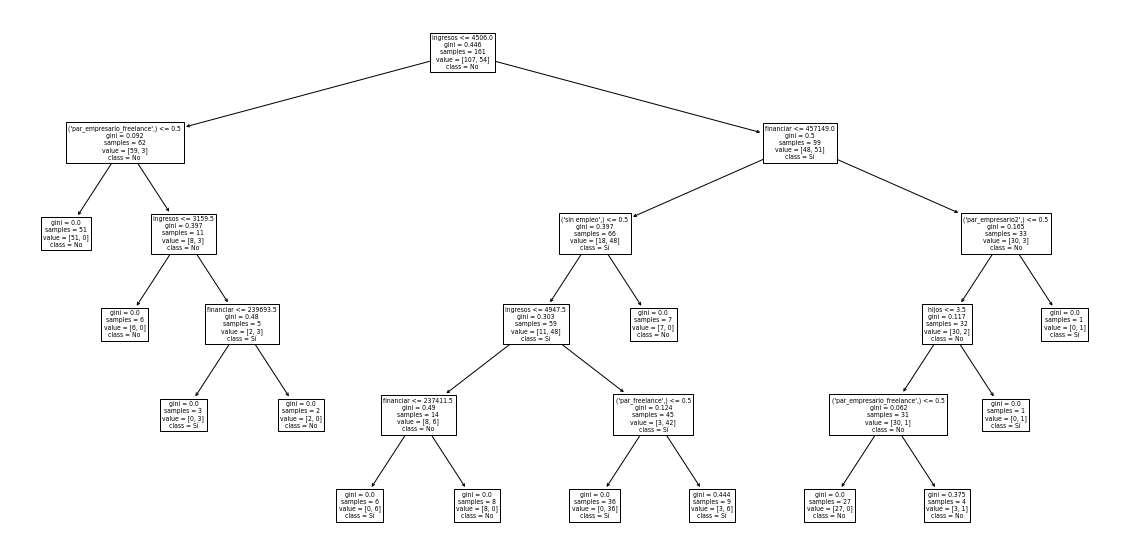

In [40]:
from sklearn import tree
# Variables y clases
fn=list(X_train)
cn=['No','Sí']

# Dibujamos el árbol
plt.figure(figsize=(20,10))
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn);
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
Las variables con más peso han sido ingresos, financiar y trabajo. La evaluación ha tenido un accuracy de 80%, lo cual es mejorable. No se ha producido overfitting.
</div>

<strong>Implementación:</strong>
Ahora usaremos _Random Forest_ o _Gradient Boosting_ para acotar el _dataset_ "hipotecas". Esta vez vamos a optimizar el modelo para obtener los mejores resultados posibles. Tal y como hemos visto en el ejercicio anterior, seguiremos los siguientes pasos:
    
   - Utilizar el _dataset_ de _train_ para encontrar los mejores hiperparámetros haciendo _cross-validation_.
   - Entrenar el modelo con _train_, predecir con test y calcular su _accuracy_ y la matriz de confusión.
</div>

In [41]:
# Definicmos los hiperparámetros que probaremos
n_estimators = [5,10,50]
max_depth = range(1,11)
parameters = {
    "n_estimators" : n_estimators,
    "max_depth": max_depth
}

# Buscamos los mejores hiperparámetros
model_rforest = RandomForestClassifier()
clf_rforest = GridSearchCV(model_rforest, parameters, scoring = 'accuracy')
grid_search = clf_rforest.fit(X_train,y_train)

print(f"Los hiperparámetros con mayor precisión han sido los siguientes: {str(grid_search.best_params_)}")

Los hiperparámetros con mayor precisión han sido los siguientes: {'max_depth': 7, 'n_estimators': 10}


El accuracy del modelo obtenido sobre train y test ha sido del 87.805 % 

El confusion matrix ha sido el siguiente:


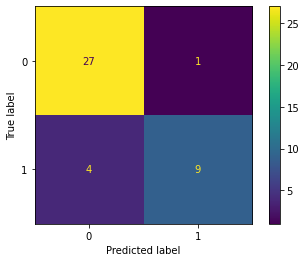

In [42]:
# Entrenamos el modelo con los mejores hiperparámetros
clf = RandomForestClassifier(n_estimators = 50, max_depth = 8)
modelo = clf.fit(X_train, y_train)
y_pred= modelo.predict(X_test)

# Accuracy y matriz de confusión
accu = accuracy_score(y_test, y_pred)
print(f'El accuracy del modelo obtenido sobre train y test ha sido del {round(accu*100,3)} % \n')
print('El confusion matrix ha sido el siguiente:')
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

Un _Random Forest_ / _Gradient Boosting_ no es tan fácil de interpretar como un simple _Decision Tree_. No podemos dibujar el árbol, porque son combinaciones de muchos árboles, pero si que podemos saber cuáles han sido las variables más decisivas a la hora de generar el modelo. Para saberlo, no podemos hacerlo a ojo mirando cómo se divide el árbol, sino que lo podemos consultar al modelo mediante la _feature importance_ de este.

<strong>Implementación:</strong>
Mostraremos cada variable del modelo fitado, junto con su _feature importance_.
</div>

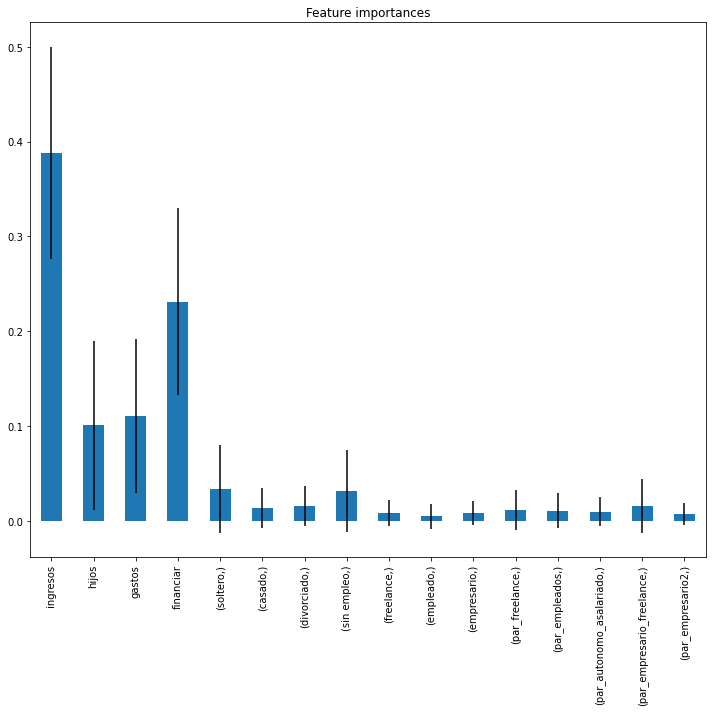

In [43]:
# Mostramos cada variable del modelo fitado, junto con su feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances,index=X_test.columns.tolist())
fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
Las variables que más peso han tenido han sido los ingresos, el dinero a financiar, y gastos, en ese orden. La precisión obtenida ha sido del 90.244%, que con el Random Forest ha crecido considerablemente. No se ha producido _overfitting_.
</div>

### 2.4. Predicción de nuevos casos

Hasta ahora hemos entrenado un modelo y hemos evaluado en test para hacernos una idea de la precisión de nuestro modelo con datos reales. Ahora vamos a utilizarlo.

<strong>Implementación:</strong>

Suponemos que trabajamos en un banco y nos visitan clientes que quieren una hipoteca. Aunque se ha de realizar un estudio a fondo de cada caso, así _a priori_ utilizaremos el clasificador entrenado para tener una idea de si se les concederá la hipoteca o no.
   
   - Caso 1: Familia con unos ingresos de 2.000 € y unos gastos de 500 €, la pareja son empresarios y no tienen hijos. Necesitarían para tener la casa de sus sueños una financiación de 200.000 €.
   - Caso 2: Familia con unos ingresos de 6.000 € y unos gastos de 3.400 €, la pareja uno es asalariado y el otro autónomo con dos hijos a su cargo. Necesitarían para tener la casa de sus sueños una financiación de 320.000 €.
   - Caso 3: Una mujer soltera con unos ingresos de 9.000 € y unos gastos de 2.250 €, con un hijo a su cargo y de profesión autónoma. Necesitaría una financiación de 39.000 €.

In [44]:
# Caso 1:
caso1 = [2000,0,500,200000,0,1,0,0,0,0,0,0,0,0,0,1]
caso2 = [6000,2,3400,320000,0,1,0,0,0,0,0,0,0,1,0,0]
caso3 = [9000,1,2250,39000,1,0,0,0,1,0,0,0,0,0,0,0]
pred_1 = modelo.predict([caso1])
pred_2 = modelo.predict([caso2])
pred_3 = modelo.predict([caso3])

In [45]:
print(f"La predicción en el caso 1 ha sido {pred_1} \n")
print(f"La predicción en el caso 2 ha sido {pred_2} \n")
print(f"La predicción en el caso 3 ha sido {pred_3} \n")

La predicción en el caso 1 ha sido [0] 

La predicción en el caso 2 ha sido [1] 

La predicción en el caso 3 ha sido [1] 



Es decir, que en los casos 2 y 3 se les concedería la hipoteca. En cambio, en el caso 1 no sería así (se puede ver lógico ya que no disponen de ingresos altos).